In [1]:
#
# NCFApp
# New Customers Forecast Application
# Programma creato per il forecast dei clienti
# 

import numpy             as np    # libreria per la gestione dei numeri
import pandas            as pd    # libreria per la gestione del file csv
import seaborn           as sb    # libreria per la costruzione di grafici
import matplotlib.pyplot as plt   # libreria ausiliaria per la costruzione di grafici
import Tkinter           as tk    # libreria per l'interfaccia grafica
import PIL                        # libreria per la gestione delle immagini
from statsmodels.tsa.stattools    import acf, pacf, adfuller, arma_order_select_ic
from statsmodels.tsa.seasonal     import seasonal_decompose
from statsmodels.tsa.arima_model  import ARIMA, ARIMAResults
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carica il dataframe dei dati dal file csv e converte la colonna 'MESE' da stringa a data
df_sstor = pd.read_csv('NCFAdati.csv',sep=',',index_col=0, parse_dates=True, infer_datetime_format=True)

# Funzione che ritorna l'ultimo consuntivo caricato
def Lastcons():
    df_mesi = df_sstor.index
    return max(df_mesi)

# Funzione che prepara un grafico e lo salva in una figura
def SimplePlot(SeriePandas=None,LabelofSerie=None):
    plt.plot(SeriePandas,label=LabelofSerie)
    plt.legend()
    return plt.figure()





#df_sstor['MESE']=pd.to_datetime(df_sstor['MESE'],format='%Y/%m')

/home/kaidan/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
# Funzione che data una serie ne calcola il forecast
# l'argomento è la serie storica originale
def Forecast(TMS_orig = None):
    
    def test_stationarity(tms = None) :
        # Dickey - Fuller test
        # H0 : la serie non è stazionaria
        # ritorna il p-value
        dftest = adfuller(tms, autolag='AIC')
        return dftest[1]
                        
    #Elimina eventuali spazi vuoti
    TMS_orig = TMS_orig.dropna()
    
    #La serie viene tagliata ai 4 anni più recenti + 12 mesi per la differenziazione stagionale + 1 mese per la differenziazione
    if len(TMS_orig)>61 :
        TMS_orig = TMS_orig[-61:]
    elif len(TMS_orig)>49 :
        TMS_orig = TMS_orig[-49:]
    elif len(TMS_orig)>37 :
        TMS_orig = TMS_orig[-37:]
    #else :
    #    raise 0
        
    #Calcola media mobile e deviazione standard su 12 periodi
    TMS_rolmean = TMS_orig.rolling(window=12,center=False).mean()
    TMS_rolstd  = TMS_orig.rolling(window=12,center=False).std()
    
    
    plt.plot(TMS_orig, label='Original Data')
    plt.plot(TMS_rolmean, label='Rolling Mean')
    plt.plot(TMS_rolstd, label='Rolling Standard Dev.')
    plt.title('Original series, Rolling Mean and Rolling StDev')
    plt.legend()
    plt.show()
    
    if test_stationarity(TMS_orig)<0.05 :
        print '\n La serie è stazionaria \n'
    else :
        print '\n La serie non è stazionaria'
    
    # Preparazione della serie per la stazionarietà
    
    # differenziazione per la stagionalità
    TMS_diff_seas = TMS_orig - TMS_orig.shift(12)
    TMS_effetto_trend = TMS_diff_seas / 12
    
    decomposition = seasonal_decompose(TMS_orig)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    
    plt.subplot(411)
    plt.plot(TMS_orig, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    plt.show()
    
    dftest = adfuller(residual.dropna(), autolag='AIC')
    print dftest
    print 'Results of Dickey-Fuller Test:'
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    lag_acf = acf(residual.dropna(), nlags=15)
    lag_pacf = pacf(residual.dropna(), nlags=15, method='ols')

    print 'lag ACF :  ',lag_acf
    print 'lag PACF : ',lag_pacf
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
        
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()
    
    model = ARIMA(residual.dropna(),order=(1,1,0))
    results_AR = model.fit(disp=-1)  
    plt.plot(residual.dropna())
    plt.plot(results_AR.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_AR.fittedvalues.dropna()-residual.dropna())**2))
    plt.show()
    
    plt.plot(results_AR.forecast(12))
    plt.show()
    #worklist=[]
    #for i in range(12,len(SeriePandas)):
    #    worklist.insert(i-12,SeriePandas[i]-SeriePandas[i-12])
    #avgtrend = np.mean(worklist)/12
    
    #trendlist=[]
    #for i in range(0,len(SeriePandas)-1):
    #    trendlist.insert(i,i*avgtrend)
        
    #worklist1=[]
    #for i in range(0,len(SeriePandas)-1):
    #    worklist1.insert(i,SeriePandas[i]-trendlist[i])
    #constant = np.mean(worklist1)
    
    #worklist2 = worklist1-constant
    
    #return worklist2,constant

    #dftest = adfuller(tms, autolag='AIC')
    #    print dftest
    #    print 'Results of Dickey-Fuller Test:'
    #    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    #    for key,value in dftest[4].items():
    #        dfoutput['Critical Value (%s)'%key] = value
    #    print dfoutput   

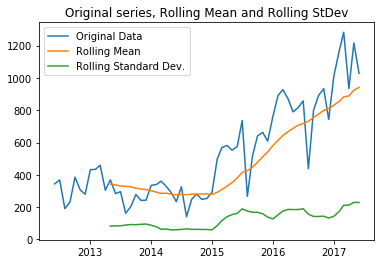


 La serie non è stazionaria


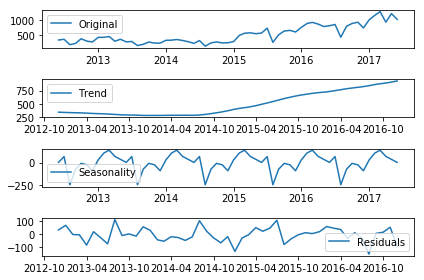

(-3.0989405506716103, 0.026631691888779147, 6, 42, {'5%': -2.9332973318216178, '1%': -3.5966356360004319, '10%': -2.6049909750566895}, 401.79772863919607)
Results of Dickey-Fuller Test:
Test Statistic                 -3.098941
p-value                         0.026632
#Lags Used                      6.000000
Number of Observations Used    42.000000
Critical Value (5%)            -2.933297
Critical Value (1%)            -3.596636
Critical Value (10%)           -2.604991
dtype: float64
lag ACF :   [ 1.          0.07735045 -0.05922363 -0.11103106 -0.07026367 -0.27886696
 -0.35203545  0.19114017  0.1908163   0.10955946  0.06146093  0.17531216
  0.0454205  -0.38494167 -0.20814119 -0.12258711]
lag PACF :  [ 1.          0.08255219 -0.07262406 -0.11031842 -0.06154619 -0.37008586
 -0.51581889  0.23717851  0.18817403  0.05125381 -0.02863027  0.02867714
  0.12689154 -0.33858029 -0.18372812 -0.28062252]


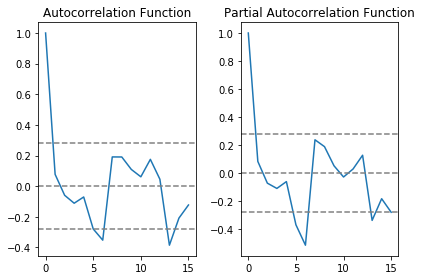

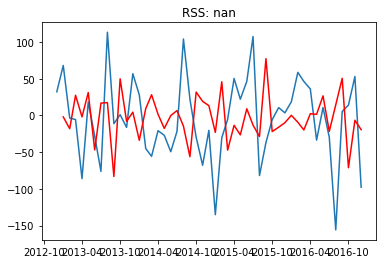

ValueError: could not broadcast input array from shape (12,2) into shape (12)

In [28]:
TimeSerie = pd.Series(df_sstor['FL_IMP'])
print Forecast(TimeSerie)

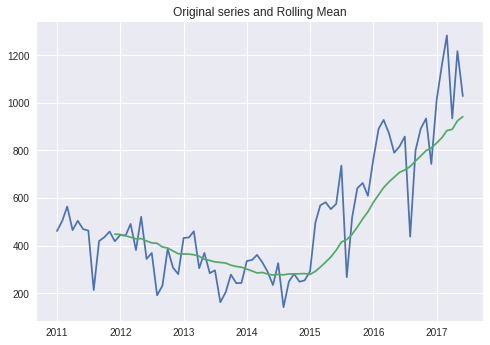

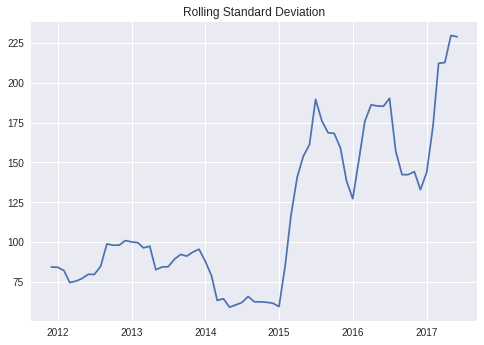

(0.27713736568232317, 0.97627090209061362, 12, 65, {'5%': -2.9071540828402367, '1%': -3.5352168748293127, '10%': -2.5911025443786984}, 787.29046527473281)
Results of Dickey-Fuller Test:
Test Statistic                  0.277137
p-value                         0.976271
#Lags Used                     12.000000
Number of Observations Used    65.000000
Critical Value (5%)            -2.907154
Critical Value (1%)            -3.535217
Critical Value (10%)           -2.591103
dtype: float64


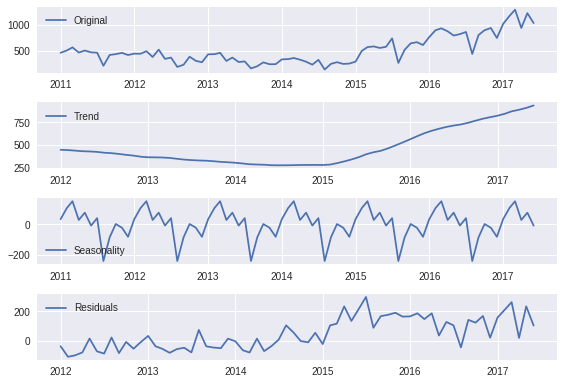

(-1.3559970125440306, 0.60318061634902209, 3, 62, {'5%': -2.9094272025108254, '1%': -3.5405226788291762, '10%': -2.5923136524453696}, 622.80467324802851)
Results of Dickey-Fuller Test:
Test Statistic                 -1.355997
p-value                         0.603181
#Lags Used                      3.000000
Number of Observations Used    62.000000
Critical Value (5%)            -2.909427
Critical Value (1%)            -3.540523
Critical Value (10%)           -2.592314
dtype: float64

Test Ljung-box sui residui per verifca White noise:
(H0 : i residui sono WN)
(array([  28.67367008,   58.09855496,   84.74685772,  110.93555148,
        128.73348319,  142.14489307,  159.54187588,  177.09464109,
        187.15831275,  196.69927749,  206.99140824,  216.45440574]), array([  8.56605222e-08,   2.42135846e-13,   2.94098203e-18,
         4.59675921e-23,   4.41892150e-26,   3.53362768e-28,
         4.00505748e-31,   4.19331507e-34,   1.61786825e-35,
         7.87074829e-37,   2.62900354e-38,   1.2

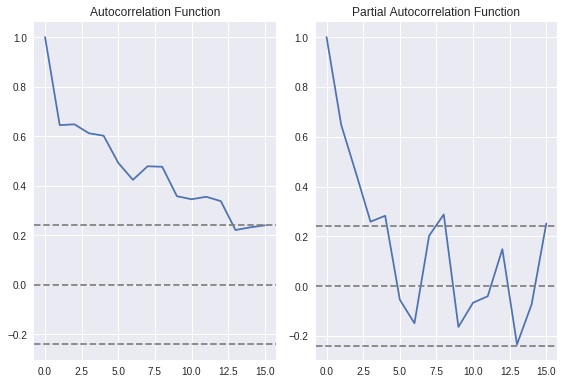

/home/manager/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LinAlgError: Array must not contain infs or NaNs

In [25]:
        
      
    
    decomposition = seasonal_decompose(SeriePandas.dropna(),two_sided=False)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    
    plt.subplot(411)
    plt.plot(SeriePandas, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    plt.show()
    
    dftest = adfuller(residual.dropna(), autolag='AIC')
    print dftest
    print 'Results of Dickey-Fuller Test:'
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    testWN = acorr_ljungbox(residual.dropna(),lags=12)
    print 
    print 'Test Ljung-box sui residui per verifca White noise:'
    print '(H0 : i residui sono WN)\n',testWN,'\n'
    
    lag_acf = acf(residual.dropna(), nlags=15)
    lag_pacf = pacf(residual.dropna(), nlags=15, method='ols')

    print 'lag ACF :  ',lag_acf
    print 'lag PACF : ',lag_pacf
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
        
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()
    
    autoregressive = residual.dropna()
    autoregressive_diff = autoregressive - autoregressive.shift()
    
    criteria_ic = arma_order_select_ic(autoregressive_diff.dropna())
    rank_AR = criteria_ic.bic_min_order[0]
    rank_MA = criteria_ic.bic_min_order[1]
    
    model = ARIMA(autoregressive_diff,order=(rank_AR,0,rank_MA))
    results_AR = model.fit(disp=-1)  
    plt.plot(autoregressive_diff)
    plt.plot(results_AR.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_AR.fittedvalues.dropna()-autoregressive_diff)**2))
    plt.show()
    
    mesi_forecast = 5
    index_forecast = pd.date_range(Lastcons(), periods=1+mesi_forecast, freq='M')
    index_forecast = index_forecast[1:]
    
    
    print results_AR.summary()
    forecast = results_AR.forecast(steps=mesi_forecast)
    print forecast
    
    forecast_value  = pd.Series(forecast[0],index=index_forecast)
    forecast_stderr = pd.Series(forecast[1],index=index_forecast)

    df_fore = pd.DataFrame.from_items([('value',forecast_value),('std error',forecast_stderr)])
    print df_fore
    
    
    

In [21]:
print residual.dropna()-residual.dropna().shift(1)

MESE
2012-01-01           NaN
2012-02-01    -71.944444
2012-03-01      9.888889
2012-04-01     19.791667
2012-05-01     94.666667
2012-06-01    -87.333333
2012-07-01    -14.945833
2012-08-01    109.200000
2012-09-01   -106.041667
2012-10-01     76.008333
2012-11-01    -46.266667
2012-12-01     44.750000
2013-01-01     42.268056
2013-02-01    -70.444444
2013-03-01    -17.152778
2013-04-01    -27.291667
2013-05-01     25.375000
2013-06-01      9.000000
2013-07-01    -31.529167
2013-08-01    152.616667
2013-09-01   -111.375000
2013-10-01     -8.158333
2013-11-01     -4.433333
2013-12-01     64.916667
2014-01-01    -18.398611
2014-02-01    -60.319444
2014-03-01    -15.736111
2014-04-01     94.375000
2014-05-01    -84.833333
2014-06-01     34.541667
                 ...    
2015-01-01    -76.648611
2015-02-01    126.972222
2015-03-01     12.013889
2015-04-01    117.041667
2015-05-01    -98.625000
2015-06-01     82.000000
2015-07-01     80.637500
2015-08-01   -208.966667
2015-09-01     78.79

In [24]:
print criteria_ic
print criteria_ic.bic_min_order[0]


{'bic_min_order': (0, 1), 'bic':             0           1           2
0  777.108658  749.045544  752.132363
1  757.751988  752.137195  756.108319
2  756.013493  756.303847  760.471660
3  754.548255  758.703242         NaN
4  758.687989  762.823067  756.751514}
0


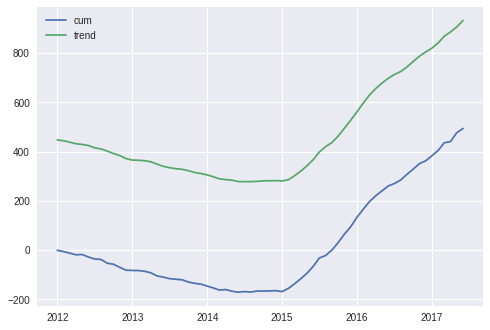

MESE
2011-01-01           NaN
2011-02-01           NaN
2011-03-01           NaN
2011-04-01           NaN
2011-05-01           NaN
2011-06-01           NaN
2011-07-01           NaN
2011-08-01           NaN
2011-09-01           NaN
2011-10-01           NaN
2011-11-01           NaN
2011-12-01           NaN
2012-01-01    447.208333
2012-02-01    443.875000
2012-03-01    438.208333
2012-04-01    431.666667
2012-05-01    428.875000
2012-06-01    424.375000
2012-07-01    415.250000
2012-08-01    410.416667
2012-09-01    401.708333
2012-10-01    391.875000
2012-11-01    383.500000
2012-12-01    371.416667
2013-01-01    365.166667
2013-02-01    364.333333
2013-03-01    362.708333
2013-04-01    358.250000
2013-05-01    348.750000
2013-06-01    339.916667
                 ...    
2015-01-01    280.541667
2015-02-01    285.291667
2015-03-01    300.500000
2015-04-01    319.708333
2015-05-01    341.208333
2015-06-01    366.375000
2015-07-01    397.666667
2015-08-01    420.000000
2015-09-01    436.45

In [4]:
reducto = (SP-SP.shift(12))/12
#rollmean = reducto.rolling(window=12,center=False).mean()
#print reducto
plt.plot(reducto.cumsum(),label='cum')
#plt.plot(rollmean)
plt.plot(trend, label='trend')
plt.legend()
plt.show()
print trend
print residual

In [76]:
print 

MESE
2011-01-01           NaN
2011-02-01           NaN
2011-03-01           NaN
2011-04-01           NaN
2011-05-01           NaN
2011-06-01           NaN
2011-07-01    447.208333
2011-08-01    443.875000
2011-09-01    438.208333
2011-10-01    431.666667
2011-11-01    428.875000
2011-12-01    424.375000
2012-01-01    415.250000
2012-02-01    410.416667
2012-03-01    401.708333
2012-04-01    391.875000
2012-05-01    383.500000
2012-06-01    371.416667
2012-07-01    365.166667
2012-08-01    364.333333
2012-09-01    362.708333
2012-10-01    358.250000
2012-11-01    348.750000
2012-12-01    339.916667
2013-01-01    334.375000
2013-02-01    330.125000
2013-03-01    327.750000
2013-04-01    322.083333
2013-05-01    314.875000
2013-06-01    310.625000
                 ...    
2015-01-01    397.666667
2015-02-01    420.000000
2015-03-01    436.458333
2015-04-01    462.666667
2015-05-01    494.958333
2015-06-01    527.041667
2015-07-01    561.375000
2015-08-01    597.333333
2015-09-01    628.70

In [4]:
class Application(tk.Frame):
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.grid()
        self.createWidgets()

    def createWidgets(self):
        self.imglogo = PIL.Image.open('Logo.jpg')
        self.imgA = self.imglogo.resize(size=(600,150))
        self.imgB = PIL.ImageTk.PhotoImage(self.imgA)
        self.canvas1 = tk.Canvas(self,width=600,height=150)
        self.canvas1.create_image(300,75,image=self.imgB)
        self.canvas1.grid()
        
        self.label = tk.Label(text = 'Last consuntive '+Lastcons())
        self.label.grid()
        
        self.quitButton = tk.Button(self, text='Quit', background='darkred', command=self.quit)
        self.quitButton.grid()
        
    def quit(self):
        self.destroy()
        return 

app = Application()
app.master.title('New Customers Forecast Application - rel. 1.0 - (C) Gianni Zattoni')
app.mainloop()


AttributeError: 'module' object has no attribute 'ImageTk'

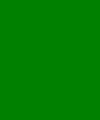

In [5]:
imA = PIL.Image.new(mode='RGB',size=(100,120),color='green')
imA

In [6]:
imglogo = PIL.Image.open('Logo.jpg')
imB = imglogo
#imB = PIL.ImageTk.PhotoImage(imglogo)
label = tk.Label(image=imB)
label.grid()

TclError: image "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080 at 0x7F301B706710>" doesn't exist

In [7]:
# Frame principale
class Application(tk.Frame):
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.grid()
        self.createWidgets()

    def createWidgets(self):
        
        self.imglogo = PIL.Image.open('Logo.jpg')
        self.imgA = self.imglogo.resize(size=(600,150))
        self.imgB = PIL.ImageTk.PhotoImage(self.imgA)
        self.canvas1 = tk.Canvas(self,width=600,height=150)
        self.canvas1.create_image(300,75,image=self.imgB)
        self.canvas1.grid()
        
        self.label = tk.Label(text = 'Last consuntive '+Lastcons())
        self.label.grid()
        
        self.quitButton = tk.Button(self, text='Quit', command=self.quit)
        self.quitButton.grid()
        
    def quit(self):
        self.destroy()
        return 

app = Application()
app.master.title('New Customers Forecast Application - rel. 1.0 - (C) Gianni Zattoni')
app.mainloop()


AttributeError: 'module' object has no attribute 'ImageTk'

In [3]:
print Lastcons()

2017/06


In [27]:
help('PIL.ImageTk')

Help on module PIL.ImageTk in PIL:

NAME
    PIL.ImageTk

FILE
    /home/kaidan/anaconda2/lib/python2.7/site-packages/PIL/ImageTk.py

DESCRIPTION
    # The Python Imaging Library.
    # $Id$
    #
    # a Tk display interface
    #
    # History:
    # 96-04-08 fl   Created
    # 96-09-06 fl   Added getimage method
    # 96-11-01 fl   Rewritten, removed image attribute and crop method
    # 97-05-09 fl   Use PyImagingPaste method instead of image type
    # 97-05-12 fl   Minor tweaks to match the IFUNC95 interface
    # 97-05-17 fl   Support the "pilbitmap" booster patch
    # 97-06-05 fl   Added file= and data= argument to image constructors
    # 98-03-09 fl   Added width and height methods to Image classes
    # 98-07-02 fl   Use default mode for "P" images without palette attribute
    # 98-07-02 fl   Explicitly destroy Tkinter image objects
    # 99-07-24 fl   Support multiple Tk interpreters (from Greg Couch)
    # 99-07-26 fl   Automatically hook into Tkinter (if possible)
    #

In [24]:
# Funzione che prepara un grafico e lo salva in una figura
def SimplePlot(SeriePandas=None,LabelofSerie=None):
    plt.plot(SeriePandas,label=LabelofSerie)
    plt.legend()
    plt.show()
    return plt.figure()

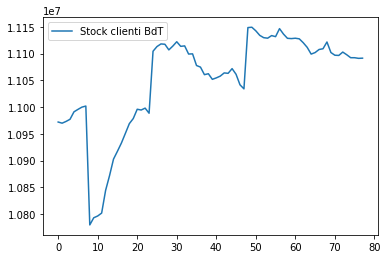

In [25]:
SimplePlot(df_totbdt['ST_BDT'],'Stock clienti BdT')

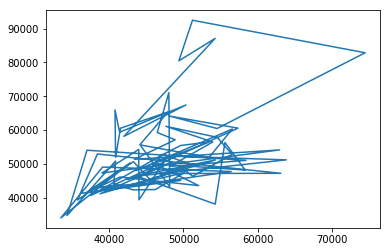

In [17]:
plt.plot(df_totbdt['CP_BDT'],df_totbdt['FL_BDT'])
plt.show()
#plt.gcf().canvas.draw()
fig = plt.figure()

In [19]:
fig
print fig

Figure(432x288)


In [9]:
import PIL

In [10]:
# create the canvas, size in pixels
canvas = tk.Canvas(width=500, height=200, bg='black')

# pack the canvas into a frame/form
canvas.grid() #expand=YES, fill=BOTH)

# load the .gif image file
logo = PIL.Image.open("Logo.jpg")
gif1 = PIL.ImageTk.PhotoImage(logo)

# put gif image on canvas
# pic's upper left corner (NW) on the canvas is at x=50 y=10
canvas.create_image(50, 10, image=gif1, anchor=N)

AttributeError: 'module' object has no attribute 'ImageTk'

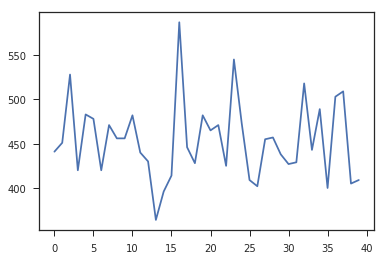

<class 'matplotlib.figure.Figure'>


IndexError: tuple index out of range

In [31]:

# prova di visualizzazione del grafico

#sb.set(style="ticks")
#pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
#pos -= pos[:, 0, np.newaxis]
#step = np.tile(range(5), 20)
#walk = np.repeat(range(20), 5)

# Initialize a grid of plots with an Axes for each walk
#grid = sb.FacetGrid(d_somma, col="walk", hue="walk", col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
#grid.map(plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(w_pad=1)



print type(fig)
graphic = tk.Canvas(app)
q = graphic.create_image(x=1, y=1, image=fig) #canvas.get_tk_widget().grid(row=1,column=24)
canvas.draw()


# create the canvas, size in pixels
#canvas = Canvas(width=300, height=200, bg='black')

# pack the canvas into a frame/form
#canvas.pack(expand=YES, fill=BOTH)

# load the .gif image file
#gif1 = PhotoImage(file='small_globe.gif')

# put gif image on canvas
# pic's upper left corner (NW) on the canvas is at x=50 y=10
#canvas.create_image(50, 10, image=gif1, anchor=N

In [ ]:
import 